## Library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np
import random
from collections import OrderedDict, ChainMap, Counter
from tqdm.asyncio import tqdm
import math
import matplotlib.pyplot as plt

# for reproducible results
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cpu')
# gpu
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda:0')
print(device)

cuda:0


## Data processing

In [2]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))]) # scale from [0,255] to [0,1] and make mean and std to 0.0 and 1.0 respectively
training_dataset = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data/mnist/', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 376608643.91it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 29807011.28it/s]


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 100819152.39it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23461242.33it/s]


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



In [3]:
# sort by labels
sorted_indices = torch.argsort(torch.Tensor(training_dataset.targets))
sorted_training_dataset = torch.utils.data.Subset(training_dataset, sorted_indices)

# partition data into shards
def prepare_datashards(num_clients, num_shards, strict=False):
    training_datashards = []

    shards = []
    # partition by class
    if strict:
        number_of_classes = len(sorted_training_dataset.dataset.classes)
        shards_per_class = num_shards // number_of_classes

        ptr = 0
        # for each class
        for label, size in sorted(Counter(sorted_training_dataset.dataset.targets.tolist()).items()):
            shard_size = math.ceil(size / shards_per_class)

            # for each shard
            for i in range(shards_per_class):
                shard = []
                # fill shard of shard_size
                for j in range(shard_size):
                    shard.append(sorted_training_dataset[ptr])
                    ptr += 1
                    # break for next class
                    if ptr >= len(sorted_training_dataset) or sorted_training_dataset[ptr][1] != label:
                        break
                shards.append(shard)

    # partition by size
    else:
        shard_size = len(sorted_training_dataset) // num_shards

        # for each shard
        for i in range(num_shards):
            shard = []
            # fill shard of shard_size
            for j in range(shard_size):
                shard.append(sorted_training_dataset[i * shard_size + j])
            shards.append(shard)
    
    # shuffled shard ids
    random.seed(seed)
    shard_ids = random.sample(list(range(num_shards)), num_shards)
    print("Shards order - {}".format(shard_ids))

    # for each client
    for k in range(num_clients):
        client_shards = []
        # number of shards per client
        shards_per_client = num_shards // num_clients
        for s in range(shards_per_client):
            id = shard_ids[k * shards_per_client + s]
            client_shards.append(shards[id])
        training_datashards.append(client_shards)

    return training_datashards

## Global

In [4]:
# clients training mode
PARALLEL_TRAINING = True

# clients and shards
num_clients = 100
num_shards = 200

# prepare training data
training_datashards = prepare_datashards(num_clients, num_shards)

Shards order - [163, 28, 6, 189, 70, 62, 57, 35, 188, 26, 173, 139, 22, 151, 108, 8, 7, 23, 55, 59, 129, 154, 197, 143, 50, 166, 191, 107, 56, 114, 150, 71, 1, 40, 185, 87, 168, 39, 181, 86, 190, 182, 97, 24, 91, 88, 67, 11, 117, 137, 31, 96, 20, 141, 75, 92, 49, 17, 152, 58, 74, 147, 180, 25, 157, 199, 116, 93, 41, 94, 90, 53, 68, 89, 119, 164, 82, 9, 77, 81, 21, 127, 132, 149, 138, 169, 48, 34, 120, 178, 134, 198, 124, 131, 98, 99, 183, 29, 4, 174, 51, 112, 184, 27, 72, 155, 100, 148, 83, 63, 175, 123, 140, 18, 33, 142, 133, 109, 118, 85, 196, 54, 79, 104, 46, 165, 84, 65, 179, 146, 177, 14, 19, 115, 78, 135, 176, 156, 38, 102, 80, 16, 192, 161, 0, 43, 145, 103, 95, 105, 113, 73, 106, 125, 52, 160, 144, 10, 60, 171, 172, 32, 195, 61, 69, 153, 36, 12, 122, 37, 194, 5, 110, 47, 162, 186, 126, 42, 15, 159, 3, 30, 130, 45, 167, 158, 76, 128, 170, 136, 44, 64, 2, 13, 121, 111, 193, 101, 187, 66]


## Model

In [5]:
class CNN(nn.Module):
    # https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html#specify-how-data-will-pass-through-your-model
    def __init__(self):
        super(CNN, self).__init__()
        # 5x5 convolution layer with 32 channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding='same')
        # 5x5 convolution layer with 64 channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='same')
        # fully connected layer with 512 units, in_features = channels * height * width from conv2
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)

    # x represents our data
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        # Use the rectified-linear activation function over x
        x = F.relu(x)
        # Run max pooling over x
        x = F.max_pool2d(x, kernel_size=2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Flatten x with start_dim=1
        x = torch.flatten(x, start_dim=1)
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output

In [6]:
num_params = sum(p.numel() for p in CNN().parameters())
print("Total number of parameters:", num_params)

Total number of parameters: 1663370


In [7]:
for p in CNN().parameters():
    print(p.shape)

torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([512, 3136])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


## Client


In [8]:
class Client():
    def __init__(self, k, model, args):
        # inititalize client
        self.id = k
        self.model = model
        self.args = args

        # load dataset
        self.dataset = []
        self._load_dataset(k)
        self.training_loader = torch.utils.data.DataLoader(self.dataset, batch_size=self.args['B'], shuffle=True)

        # state_dict
        self.state_dict = self.model.state_dict()

    def _load_dataset(self, k):
        # load dataset
        for shard in training_datashards[k]:
            self.dataset += shard
        return

    def labels(self):
        return dict(Counter(data[1] for data in self.dataset))

    def size(self):
        return len(self.dataset)

    async def update(self):
        # load state_dict
        self.model.load_state_dict(self.state_dict)

        # Sets the module in training mode
        self.model.train(True)

        optimizer = optim.SGD(self.model.parameters(), lr=self.args['lr'])
        loss_fn = nn.CrossEntropyLoss()

        # https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
        for epoch in range(self.args['E']):
            for inputs, labels in self.training_loader:
                # Every data instance is an input + label pair
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero your gradients for every batch!
                optimizer.zero_grad()

                # Make predictions for this batch
                outputs = self.model(inputs)

                # Compute the loss and its gradients
                loss = loss_fn(outputs, labels)
                loss.backward()

                # Adjust learning weights
                optimizer.step()
        
        # save state_dict
        self.state_dict = self.model.state_dict()

        return { self.id: self.state_dict }

    def model_sync(self, state_dict):
        self.state_dict = state_dict

## Server

In [9]:
class Server():
    def __init__(self, args):
        self.model = CNN().to(device)
        # number of rounds of communication
        self.rounds = 0
        # client fraction C
        self.c = args['C']
        # client list
        self.clients = []
        # inititalize clients according to num_clients
        if PARALLEL_TRAINING:
            for k in range(num_clients):
                # torch.manual_seed(seed)
                client_model = CNN().to(device)
                client = Client(k, client_model, args)
                self.clients.append(client)
        else:
            # torch.manual_seed(seed)
            client_model = CNN().to(device)
            for k in range(num_clients):
                client = Client(k, client_model, args)
                self.clients.append(client)

    def _fed_avg(self, state_dicts):
        # total number of data
        len_total = 0
        for k in ChainMap(*state_dicts).keys():
            len_total += self.clients[k].size()

        dict = OrderedDict()
        # for each client's state_dict
        for k, state_dict in ChainMap(*state_dicts).items():
            # for each tensor param
            for param_tensor in self.model.state_dict().keys():
                # param = w0 * wf0 + w1 * wf1 + ... wk * wfk
                if param_tensor in dict:
                    dict[param_tensor] += state_dict[param_tensor] * (self.clients[k].size() / len_total)
                else:
                    dict[param_tensor] = state_dict[param_tensor] * (self.clients[k].size() / len_total)

        return dict

    def clients_info(self):
        for i, client in enumerate(self.clients):
            print("Client {} - {}".format(i, client.labels()))

    async def model_sync(self):
        selected_clients = self.clients

        # clients random selection
        if self.c < 1.0:
            # clients per round
            k = max(int(self.c * num_clients), 1)
            # client selection
            random.seed(self.rounds)
            selected_clients = random.sample(self.clients, k=k)
            client_ids = []
            for client in selected_clients:
                client_ids.append(client.id)
            print("Selected clients - {}".format(client_ids))

        state_dicts = []
        # for each selected client do client update
        if PARALLEL_TRAINING:
            state_dicts = await tqdm.gather(*[client.update() for client in selected_clients])
        else:
            for client in tqdm(selected_clients):
                state_dict = await client.update()
                state_dicts.append(state_dict)
        
        # update server weights
        avg_state_dict = self._fed_avg(state_dicts)
        self.model.load_state_dict(avg_state_dict)

        # sync with all clients
        for client in self.clients:
            client.model_sync(avg_state_dict)

        # increase rounds count
        self.rounds += 1

In [10]:
def test_model(model):
    # https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-analysis-train-model#test-the-model-on-the-test-data
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()

    # Sets the module in evaluate mode
    model.eval()
    model.to(device)
    
    correct = 0
    loss = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Every data instance is an input + label pair
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Make predictions for this batch
            outputs = model(inputs)
            _, pred = torch.max(outputs, dim=1)
            total += labels.size(0)

            # Compute the loss and accuracy
            loss += loss_fn(outputs, labels).item()
            correct += (pred == labels).sum().item()

    loss /= total
    accuracy = correct / total

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        loss, correct, total, accuracy * 100))
    return accuracy, loss

In [11]:
async def execute(server, T, target_accuracy, es=None, min_delta=0.0, patience=0):
    _patience = patience

    # initial values
    record_round = 0
    best_round = 0
    best_accuracy = 0.0
    last_loss = None
    state_dict, accuracies, losses = [], [], []

    # loop until rounds
    while server.rounds < T:
        print("Round {}/{}".format(server.rounds + 1, T))

        # model sync
        await server.model_sync()
        
        # test accuracy
        accuracy, loss = test_model(server.model)

        if accuracy >= best_accuracy:
            # save best record
            best_accuracy = accuracy
            best_round = server.rounds

            if best_accuracy >= target_accuracy or server.rounds > T - 10:
                # save state_dict
                state_dict = server.model.state_dict()

        # statistics
        accuracies.append(accuracy)
        losses.append(loss)

        # early stopping
        if es == 'loss':
            if last_loss is None:
                last_loss = loss
                continue

            if last_loss - loss < min_delta:
                # break if patience equal to 0
                if patience == 0:
                    break
                else:
                    patience -= 1
            else:
                # reset patience and update last loss
                patience = _patience
                last_loss = loss

        # target accuracy reached
        if accuracy >= target_accuracy and record_round == 0:
            record_round = server.rounds

    if record_round > 0:
        print("Target accuracy reached at round: {}".format(record_round))
    print("Best round: {}, accuracy: {}".format(best_round, best_accuracy))

    return state_dict, accuracies, losses

## Execute

In [12]:
# model params
args = { 'C': 1.0, 'E': 5, 'B': 10 , 'lr': 0.05 }

# server
server = Server(args)

# data distribution
print("Training dataset - {}".format(dict(sorted(Counter(training_dataset.targets.tolist()).items()))))
server.clients_info()

Training dataset - {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Client 0 - {8: 300, 1: 300}
Client 1 - {0: 300, 9: 300}
Client 2 - {3: 577, 2: 23}
Client 3 - {2: 300, 1: 300}
Client 4 - {9: 300, 1: 300}
Client 5 - {8: 300, 6: 235, 7: 65}
Client 6 - {1: 300, 7: 300}
Client 7 - {5: 300, 0: 300}
Client 8 - {0: 300, 1: 300}
Client 9 - {2: 600}
Client 10 - {6: 300, 7: 300}
Client 11 - {9: 300, 7: 300}
Client 12 - {2: 300, 8: 300}
Client 13 - {9: 300, 5: 300}
Client 14 - {2: 300, 5: 300}
Client 15 - {7: 300, 3: 300}
Client 16 - {0: 300, 1: 300}
Client 17 - {9: 300, 4: 300}
Client 18 - {8: 300, 1: 300}
Client 19 - {9: 300, 4: 300}
Client 20 - {9: 600}
Client 21 - {4: 300, 1: 300}
Client 22 - {4: 600}
Client 23 - {3: 300, 0: 300}
Client 24 - {5: 300, 6: 300}
Client 25 - {1: 300, 4: 300}
Client 26 - {1: 300, 7: 300}
Client 27 - {3: 300, 4: 300}
Client 28 - {2: 300, 0: 300}
Client 29 - {7: 300, 2: 300}
Client 30 - {3: 300, 7: 300}
Client 31 - {8: 51,

In [13]:
# rounds and target accuracy
T = 200
target_accuracy = 0.99

state_dict, accuracies, losses = await execute(server, T, target_accuracy)

# save model to file
torch.save(state_dict, "cnn_state_dict.pth")

Round 1/200


100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


Test set: Average loss: 0.2302, Accuracy: 1135/10000 (11.35%)
Round 2/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.2180, Accuracy: 3340/10000 (33.40%)
Round 3/200


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


Test set: Average loss: 0.1692, Accuracy: 6681/10000 (66.81%)
Round 4/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.1208, Accuracy: 7669/10000 (76.69%)
Round 5/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0864, Accuracy: 8522/10000 (85.22%)
Round 6/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0646, Accuracy: 8843/10000 (88.43%)
Round 7/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0546, Accuracy: 8900/10000 (89.00%)
Round 8/200


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Test set: Average loss: 0.0444, Accuracy: 9017/10000 (90.17%)
Round 9/200


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


Test set: Average loss: 0.0361, Accuracy: 9129/10000 (91.29%)
Round 10/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0302, Accuracy: 9244/10000 (92.44%)
Round 11/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0265, Accuracy: 9325/10000 (93.25%)
Round 12/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0232, Accuracy: 9395/10000 (93.95%)
Round 13/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0218, Accuracy: 9423/10000 (94.23%)
Round 14/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0202, Accuracy: 9460/10000 (94.60%)
Round 15/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0188, Accuracy: 9473/10000 (94.73%)
Round 16/200


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Test set: Average loss: 0.0176, Accuracy: 9506/10000 (95.06%)
Round 17/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0159, Accuracy: 9540/10000 (95.40%)
Round 18/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0152, Accuracy: 9558/10000 (95.58%)
Round 19/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0146, Accuracy: 9555/10000 (95.55%)
Round 20/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0136, Accuracy: 9585/10000 (95.85%)
Round 21/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0131, Accuracy: 9605/10000 (96.05%)
Round 22/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0125, Accuracy: 9621/10000 (96.21%)
Round 23/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0118, Accuracy: 9636/10000 (96.36%)
Round 24/200


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Test set: Average loss: 0.0116, Accuracy: 9646/10000 (96.46%)
Round 25/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0111, Accuracy: 9650/10000 (96.50%)
Round 26/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0106, Accuracy: 9663/10000 (96.63%)
Round 27/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0106, Accuracy: 9667/10000 (96.67%)
Round 28/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0104, Accuracy: 9678/10000 (96.78%)
Round 29/200


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Test set: Average loss: 0.0097, Accuracy: 9698/10000 (96.98%)
Round 30/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0094, Accuracy: 9708/10000 (97.08%)
Round 31/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0091, Accuracy: 9718/10000 (97.18%)
Round 32/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0089, Accuracy: 9717/10000 (97.17%)
Round 33/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0088, Accuracy: 9724/10000 (97.24%)
Round 34/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0084, Accuracy: 9734/10000 (97.34%)
Round 35/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0082, Accuracy: 9737/10000 (97.37%)
Round 36/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0081, Accuracy: 9745/10000 (97.45%)
Round 37/200


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Test set: Average loss: 0.0082, Accuracy: 9743/10000 (97.43%)
Round 38/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0078, Accuracy: 9757/10000 (97.57%)
Round 39/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0077, Accuracy: 9760/10000 (97.60%)
Round 40/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0075, Accuracy: 9768/10000 (97.68%)
Round 41/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0075, Accuracy: 9765/10000 (97.65%)
Round 42/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0075, Accuracy: 9770/10000 (97.70%)
Round 43/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0072, Accuracy: 9777/10000 (97.77%)
Round 44/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0069, Accuracy: 9782/10000 (97.82%)
Round 45/200


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Test set: Average loss: 0.0068, Accuracy: 9790/10000 (97.90%)
Round 46/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0068, Accuracy: 9789/10000 (97.89%)
Round 47/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0067, Accuracy: 9793/10000 (97.93%)
Round 48/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0066, Accuracy: 9793/10000 (97.93%)
Round 49/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0065, Accuracy: 9794/10000 (97.94%)
Round 50/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0065, Accuracy: 9798/10000 (97.98%)
Round 51/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0063, Accuracy: 9798/10000 (97.98%)
Round 52/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0062, Accuracy: 9796/10000 (97.96%)
Round 53/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0061, Accuracy: 9807/10000 (98.07%)
Round 54/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0059, Accuracy: 9805/10000 (98.05%)
Round 55/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0058, Accuracy: 9809/10000 (98.09%)
Round 56/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0059, Accuracy: 9810/10000 (98.10%)
Round 57/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0058, Accuracy: 9807/10000 (98.07%)
Round 58/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0056, Accuracy: 9812/10000 (98.12%)
Round 59/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0056, Accuracy: 9809/10000 (98.09%)
Round 60/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0056, Accuracy: 9812/10000 (98.12%)
Round 61/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0055, Accuracy: 9811/10000 (98.11%)
Round 62/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0055, Accuracy: 9814/10000 (98.14%)
Round 63/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0054, Accuracy: 9817/10000 (98.17%)
Round 64/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0054, Accuracy: 9823/10000 (98.23%)
Round 65/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0053, Accuracy: 9823/10000 (98.23%)
Round 66/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0052, Accuracy: 9822/10000 (98.22%)
Round 67/200


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Test set: Average loss: 0.0052, Accuracy: 9822/10000 (98.22%)
Round 68/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0051, Accuracy: 9823/10000 (98.23%)
Round 69/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0050, Accuracy: 9820/10000 (98.20%)
Round 70/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0051, Accuracy: 9823/10000 (98.23%)
Round 71/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0050, Accuracy: 9825/10000 (98.25%)
Round 72/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0050, Accuracy: 9825/10000 (98.25%)
Round 73/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0049, Accuracy: 9830/10000 (98.30%)
Round 74/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0049, Accuracy: 9834/10000 (98.34%)
Round 75/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0048, Accuracy: 9835/10000 (98.35%)
Round 76/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0048, Accuracy: 9831/10000 (98.31%)
Round 77/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0047, Accuracy: 9830/10000 (98.30%)
Round 78/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0047, Accuracy: 9834/10000 (98.34%)
Round 79/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0047, Accuracy: 9837/10000 (98.37%)
Round 80/200


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Test set: Average loss: 0.0047, Accuracy: 9837/10000 (98.37%)
Round 81/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0047, Accuracy: 9835/10000 (98.35%)
Round 82/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0047, Accuracy: 9837/10000 (98.37%)
Round 83/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0046, Accuracy: 9843/10000 (98.43%)
Round 84/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0045, Accuracy: 9842/10000 (98.42%)
Round 85/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0046, Accuracy: 9842/10000 (98.42%)
Round 86/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0045, Accuracy: 9841/10000 (98.41%)
Round 87/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0045, Accuracy: 9846/10000 (98.46%)
Round 88/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0045, Accuracy: 9843/10000 (98.43%)
Round 89/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0045, Accuracy: 9839/10000 (98.39%)
Round 90/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0045, Accuracy: 9843/10000 (98.43%)
Round 91/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0044, Accuracy: 9844/10000 (98.44%)
Round 92/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0044, Accuracy: 9848/10000 (98.48%)
Round 93/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0044, Accuracy: 9847/10000 (98.47%)
Round 94/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0043, Accuracy: 9853/10000 (98.53%)
Round 95/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0043, Accuracy: 9852/10000 (98.52%)
Round 96/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0043, Accuracy: 9845/10000 (98.45%)
Round 97/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0042, Accuracy: 9849/10000 (98.49%)
Round 98/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0042, Accuracy: 9848/10000 (98.48%)
Round 99/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0042, Accuracy: 9852/10000 (98.52%)
Round 100/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0041, Accuracy: 9853/10000 (98.53%)
Round 101/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0041, Accuracy: 9857/10000 (98.57%)
Round 102/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0041, Accuracy: 9854/10000 (98.54%)
Round 103/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0042, Accuracy: 9856/10000 (98.56%)
Round 104/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0041, Accuracy: 9855/10000 (98.55%)
Round 105/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0041, Accuracy: 9854/10000 (98.54%)
Round 106/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0041, Accuracy: 9856/10000 (98.56%)
Round 107/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0041, Accuracy: 9858/10000 (98.58%)
Round 108/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0040, Accuracy: 9856/10000 (98.56%)
Round 109/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0041, Accuracy: 9854/10000 (98.54%)
Round 110/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0040, Accuracy: 9853/10000 (98.53%)
Round 111/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0040, Accuracy: 9855/10000 (98.55%)
Round 112/200


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Test set: Average loss: 0.0040, Accuracy: 9857/10000 (98.57%)
Round 113/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0040, Accuracy: 9857/10000 (98.57%)
Round 114/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0040, Accuracy: 9857/10000 (98.57%)
Round 115/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0040, Accuracy: 9858/10000 (98.58%)
Round 116/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0039, Accuracy: 9863/10000 (98.63%)
Round 117/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0039, Accuracy: 9859/10000 (98.59%)
Round 118/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0039, Accuracy: 9858/10000 (98.58%)
Round 119/200


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Test set: Average loss: 0.0039, Accuracy: 9862/10000 (98.62%)
Round 120/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0039, Accuracy: 9854/10000 (98.54%)
Round 121/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0039, Accuracy: 9858/10000 (98.58%)
Round 122/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0039, Accuracy: 9863/10000 (98.63%)
Round 123/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0038, Accuracy: 9861/10000 (98.61%)
Round 124/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0038, Accuracy: 9863/10000 (98.63%)
Round 125/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0038, Accuracy: 9862/10000 (98.62%)
Round 126/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0038, Accuracy: 9861/10000 (98.61%)
Round 127/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0038, Accuracy: 9860/10000 (98.60%)
Round 128/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0038, Accuracy: 9863/10000 (98.63%)
Round 129/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0038, Accuracy: 9868/10000 (98.68%)
Round 130/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0038, Accuracy: 9866/10000 (98.66%)
Round 131/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0038, Accuracy: 9867/10000 (98.67%)
Round 132/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0038, Accuracy: 9860/10000 (98.60%)
Round 133/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0038, Accuracy: 9862/10000 (98.62%)
Round 134/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0038, Accuracy: 9863/10000 (98.63%)
Round 135/200


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Test set: Average loss: 0.0038, Accuracy: 9866/10000 (98.66%)
Round 136/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0037, Accuracy: 9869/10000 (98.69%)
Round 137/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0037, Accuracy: 9870/10000 (98.70%)
Round 138/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0037, Accuracy: 9871/10000 (98.71%)
Round 139/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0037, Accuracy: 9871/10000 (98.71%)
Round 140/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0037, Accuracy: 9872/10000 (98.72%)
Round 141/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0037, Accuracy: 9872/10000 (98.72%)
Round 142/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0036, Accuracy: 9872/10000 (98.72%)
Round 143/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0036, Accuracy: 9875/10000 (98.75%)
Round 144/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0036, Accuracy: 9872/10000 (98.72%)
Round 145/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0036, Accuracy: 9872/10000 (98.72%)
Round 146/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0036, Accuracy: 9872/10000 (98.72%)
Round 147/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0036, Accuracy: 9870/10000 (98.70%)
Round 148/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0036, Accuracy: 9871/10000 (98.71%)
Round 149/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0036, Accuracy: 9873/10000 (98.73%)
Round 150/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0036, Accuracy: 9877/10000 (98.77%)
Round 151/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0036, Accuracy: 9876/10000 (98.76%)
Round 152/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0037, Accuracy: 9872/10000 (98.72%)
Round 153/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0036, Accuracy: 9876/10000 (98.76%)
Round 154/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0036, Accuracy: 9877/10000 (98.77%)
Round 155/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0035, Accuracy: 9878/10000 (98.78%)
Round 156/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0036, Accuracy: 9876/10000 (98.76%)
Round 157/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0036, Accuracy: 9873/10000 (98.73%)
Round 158/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0037, Accuracy: 9873/10000 (98.73%)
Round 159/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0036, Accuracy: 9879/10000 (98.79%)
Round 160/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0037, Accuracy: 9872/10000 (98.72%)
Round 161/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0037, Accuracy: 9875/10000 (98.75%)
Round 162/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0036, Accuracy: 9878/10000 (98.78%)
Round 163/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0035, Accuracy: 9878/10000 (98.78%)
Round 164/200


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Test set: Average loss: 0.0036, Accuracy: 9877/10000 (98.77%)
Round 165/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0035, Accuracy: 9875/10000 (98.75%)
Round 166/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0035, Accuracy: 9878/10000 (98.78%)
Round 167/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0035, Accuracy: 9872/10000 (98.72%)
Round 168/200


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Test set: Average loss: 0.0035, Accuracy: 9874/10000 (98.74%)
Round 169/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0035, Accuracy: 9876/10000 (98.76%)
Round 170/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0036, Accuracy: 9872/10000 (98.72%)
Round 171/200


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Test set: Average loss: 0.0036, Accuracy: 9871/10000 (98.71%)
Round 172/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0035, Accuracy: 9873/10000 (98.73%)
Round 173/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0035, Accuracy: 9871/10000 (98.71%)
Round 174/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0035, Accuracy: 9873/10000 (98.73%)
Round 175/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0034, Accuracy: 9875/10000 (98.75%)
Round 176/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0035, Accuracy: 9874/10000 (98.74%)
Round 177/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0035, Accuracy: 9875/10000 (98.75%)
Round 178/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0035, Accuracy: 9877/10000 (98.77%)
Round 179/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0034, Accuracy: 9877/10000 (98.77%)
Round 180/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0035, Accuracy: 9880/10000 (98.80%)
Round 181/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0035, Accuracy: 9879/10000 (98.79%)
Round 182/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0035, Accuracy: 9874/10000 (98.74%)
Round 183/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0035, Accuracy: 9878/10000 (98.78%)
Round 184/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0034, Accuracy: 9880/10000 (98.80%)
Round 185/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0034, Accuracy: 9882/10000 (98.82%)
Round 186/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0034, Accuracy: 9881/10000 (98.81%)
Round 187/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0034, Accuracy: 9884/10000 (98.84%)
Round 188/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0034, Accuracy: 9884/10000 (98.84%)
Round 189/200


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Test set: Average loss: 0.0034, Accuracy: 9880/10000 (98.80%)
Round 190/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0034, Accuracy: 9884/10000 (98.84%)
Round 191/200


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Test set: Average loss: 0.0034, Accuracy: 9884/10000 (98.84%)
Round 192/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0034, Accuracy: 9885/10000 (98.85%)
Round 193/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0034, Accuracy: 9884/10000 (98.84%)
Round 194/200


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


Test set: Average loss: 0.0034, Accuracy: 9887/10000 (98.87%)
Round 195/200


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Test set: Average loss: 0.0034, Accuracy: 9887/10000 (98.87%)
Round 196/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0035, Accuracy: 9885/10000 (98.85%)
Round 197/200


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Test set: Average loss: 0.0034, Accuracy: 9883/10000 (98.83%)
Round 198/200


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Test set: Average loss: 0.0034, Accuracy: 9887/10000 (98.87%)
Round 199/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0034, Accuracy: 9887/10000 (98.87%)
Round 200/200


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Test set: Average loss: 0.0034, Accuracy: 9886/10000 (98.86%)
Best round: 199, accuracy: 0.9887


## Statistics

In [14]:
# manual save to shared drive for reproducible graph
print(accuracies)

[0.1135, 0.334, 0.6681, 0.7669, 0.8522, 0.8843, 0.89, 0.9017, 0.9129, 0.9244, 0.9325, 0.9395, 0.9423, 0.946, 0.9473, 0.9506, 0.954, 0.9558, 0.9555, 0.9585, 0.9605, 0.9621, 0.9636, 0.9646, 0.965, 0.9663, 0.9667, 0.9678, 0.9698, 0.9708, 0.9718, 0.9717, 0.9724, 0.9734, 0.9737, 0.9745, 0.9743, 0.9757, 0.976, 0.9768, 0.9765, 0.977, 0.9777, 0.9782, 0.979, 0.9789, 0.9793, 0.9793, 0.9794, 0.9798, 0.9798, 0.9796, 0.9807, 0.9805, 0.9809, 0.981, 0.9807, 0.9812, 0.9809, 0.9812, 0.9811, 0.9814, 0.9817, 0.9823, 0.9823, 0.9822, 0.9822, 0.9823, 0.982, 0.9823, 0.9825, 0.9825, 0.983, 0.9834, 0.9835, 0.9831, 0.983, 0.9834, 0.9837, 0.9837, 0.9835, 0.9837, 0.9843, 0.9842, 0.9842, 0.9841, 0.9846, 0.9843, 0.9839, 0.9843, 0.9844, 0.9848, 0.9847, 0.9853, 0.9852, 0.9845, 0.9849, 0.9848, 0.9852, 0.9853, 0.9857, 0.9854, 0.9856, 0.9855, 0.9854, 0.9856, 0.9858, 0.9856, 0.9854, 0.9853, 0.9855, 0.9857, 0.9857, 0.9857, 0.9858, 0.9863, 0.9859, 0.9858, 0.9862, 0.9854, 0.9858, 0.9863, 0.9861, 0.9863, 0.9862, 0.9861, 0.98

In [15]:
# manual save to shared drive for reproducible graph
print(losses)

[0.23023652303218842, 0.21798958876132965, 0.16924195820093155, 0.12081530564427376, 0.08639290699362755, 0.06463654381930828, 0.05464460504055023, 0.04440140069425106, 0.03613432479724288, 0.030187984436005354, 0.02653738150950521, 0.023236123087909073, 0.021765100908093155, 0.020208571211714297, 0.018815152385924013, 0.01757813108782284, 0.015886729575693606, 0.015178285239893011, 0.014572399271419272, 0.013585411432920955, 0.013057811685535126, 0.01254570820281515, 0.011764712730556494, 0.011636081797385123, 0.011107777832308784, 0.010571744694866356, 0.010578264068410498, 0.010401784200532711, 0.009718818433023989, 0.009392229401468648, 0.009053768111192038, 0.008938426808509394, 0.00882233813816274, 0.00842800397224637, 0.008240394519039546, 0.008063690379883337, 0.008235328033224505, 0.007838777483782906, 0.007703785419754422, 0.007519614246512356, 0.007534594385744276, 0.007478338834449824, 0.007201680568343, 0.006920370823970734, 0.006837496308313348, 0.0067510670645315254, 0.0

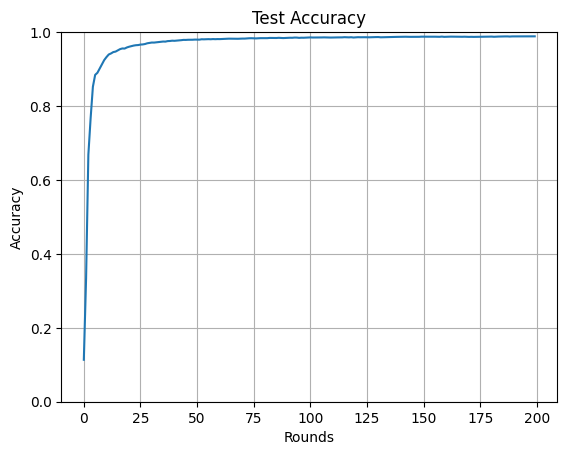

In [16]:
plt.plot(accuracies)
plt.title('Test Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()